In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [17]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3

In [3]:
dataset = np.load('../datasets/car_64.npy')


1553596416


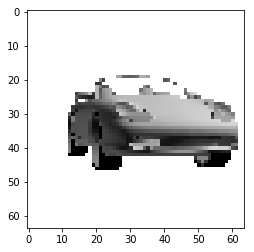

In [4]:
print(dataset.nbytes)
plt.imshow(dataset[1]/255)
plt.show()

In [5]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

3512 2809 703


In [6]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(25308, 64, 64, 3)
(101124, 64, 64, 3)


In [7]:
del dataset

In [8]:
dataset_train.nbytes

1242611712

In [9]:
train_pairs = []
start_pose = [0,9,18,27]
for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = [0,9,18,27]
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                test_pairs.append((i,j,k))


In [10]:
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(0, 9, 0)
(0, 9, 0)
(1063, 27, 5)
(404, 27, 19)


(1684, 27, 19)
(153, 18, 26)
393260


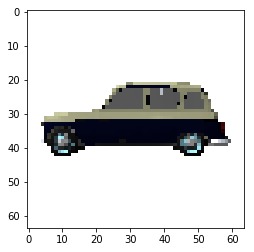

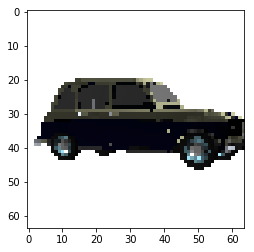

In [16]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(1063*36) + 27]
j = dataset_train[(1063*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [ ]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)


def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=lrelu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=lrelu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation_fn=act
        )

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def batch_norm(inputs_, is_training):
    out = tf.contrib.layers.batch_norm(inputs_, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss

def ce_loss(labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)
    

In [ ]:
tf.reset_default_graph()

In [ ]:
batch_size = 36
# tf Graph input (only pictures)
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (batch_size, 8, 8, 36), name="pose")

disc_inputs = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")

real_label = tf.placeholder(tf.float32, [batch_size, 1])
fake_label = tf.placeholder(tf.float32, [batch_size, 1])

In [ ]:
ae_reuse= False
disc_reuse = False

#generate coarse images from inputs_
def auto_encoder(inputs_, pose_):
    print(inputs_)
    global ae_reuse
    with tf.variable_scope('encoder', reuse=ae_reuse):
        ae_reuse = True
        _ = conv2d(inputs_, output=16 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=92 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=lrelu)
        _ = tf.concat([pose_, _], 3)

        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv1',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv2',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv3',act=lrelu)
        _ = tf.sigmoid(_)
    return _ 
    
    
# discriminator should give a fc layer
def discriminator(inputs_):
    global disc_reuse 
    with tf.variable_scope('dis', reuse=disc_reuse):
        disc_reuse = True
        ''' 
        _ = conv2d(inputs_, 4, 2, 32, 'conv1')
        _ = leaky_relu(_)
        _ = conv2d(_, 4, 2, 64, 'conv2')
        _ = batch_norm(_)
        _ = leaky_relu(_)
        _ = conv2d(_, 4, 2, 128, 'conv3')
        _ = batch_norm(_)
        _ = leaky_relu(_)
        _ = tf.reshape(_, [-1, 4 * 4 * 128])
        _ = fc(_, 1, 'fc4')
        print(_.get_shape(), "FC - Result")
        '''
        
        _ = conv2d(inputs_, output=16 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv1", act=lrelu)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv2", act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv3", act=lrelu)
        _ = batch_norm(_, True)
        _ = tf.reshape(_, [-1, 8 * 8 * 32])        
        _ = fc(_, 1, 'dis_fc1')
        return _


In [ ]:
global_step = tf.Variable(0,trainable=False)
lr = 5e-4

In [ ]:
alpha = 0.01
beta = 1.0

generated_images = auto_encoder(inputs_, pose_)
dis_fake_samples_op = discriminator(generated_images)

gen_loss_op = (alpha * ce_loss(real_label, dis_fake_samples_op)) + (beta * l1_loss(generated_images, targets_))
dis_loss_op = ce_loss(fake_label, dis_fake_samples_op) + ce_loss(real_label, discriminator(disc_inputs))

In [ ]:
disriminator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
generator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
#print (generator_vars)
dis_optimizer = tf.train.RMSPropOptimizer(lr)
dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)

gen_optimizer = tf.train.RMSPropOptimizer(lr)
gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)

In [ ]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(dataset_train[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(dataset_train[op_index])
        
        cur_pose =  np.zeros(36, dtype='uint8')
        cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
        pose.append(np.broadcast_to(cur_pose,(8,8,36)))
        
    batch = np.array(batch, dytpe='float32')
    batch_labels = np.array(batch_labels, dytpe='float32')
    pose = np.array(pose, dytpe='float32')
        
    
        

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 5
total_images = len(train_pairs)
step = 0

r = total_images // batch_size
#print(data_train.shape, "X1")
#d_inputs = data_train[399*batch_size : (400)*batch_size]
#print(d_inputs.shape, "X2")

for epoch in range(epochs):
    for ii in range(r):
        step += 1
        zeros = np.zeros([batch_size, 1])
        ones = np.ones([batch_size, 1])
        
        #batch = data_train[ii*batch_size : (ii+1)*batch_size]
        #batch_labels = train_labels[ii*batch_size : (ii+1)*batch_size]
        #pose_labels = pose[ii*batch_size : (ii+1)*batch_size]
        
        d_pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        
        batch, batch_labels, pose_labels = get_batch_data(d_pairs)
        
        k = np.random.randint(1,r-1)
        
        d_inputs = data_train[k*batch_size : (k+1)*batch_size]

        gen_feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                         real_label: ones}

        _, gen_loss = sess.run([gen_train_op, gen_loss_op], feed_dict = gen_feed_dict)
        
        
        dis_feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                         fake_label: zeros, real_label: ones, disc_inputs: d_inputs}

        _, dis_loss = sess.run([dis_train_op, dis_loss_op], feed_dict = dis_feed_dict)

        #if step % 10 == 0:
        #    print('Epoch {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(epoch, dis_loss, gen_loss))
            
    print('Epoch {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(epoch, dis_loss, gen_loss))